In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

from tqdm import tqdm
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

2022-08-08 18:42:50.803013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 18:42:50.803039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

https://medium.com/@majpaw1996/anomaly-detection-in-computer-vision-with-ssim-ae-2d5256ffc06b
https://github.com/SubhamIO/AnomalyDetection---Deep-AUTOENCODERS

In [25]:
train_path = "../../data/chest_xray/train"
val_path = "../../data/chest_xray/val"
test_path = "../../data/chest_xray/test"

anomaly_path = "../../data/chest_xray/PN_test_copy/"

In [26]:
def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [27]:
dsize =(64, 64)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [28]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [35]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

anomaly_org, y_anomaly = load_images(anomaly_path, labels, dsize = dsize)

100%|██████████| 1341/1341 [00:14<00:00, 90.46it/s]
0it [00:00, ?it/s]
100%|██████████| 8/8 [00:00<00:00, 156.09it/s]
0it [00:00, ?it/s]
100%|██████████| 234/234 [00:01<00:00, 155.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 390/390 [00:00<00:00, 430.61it/s]


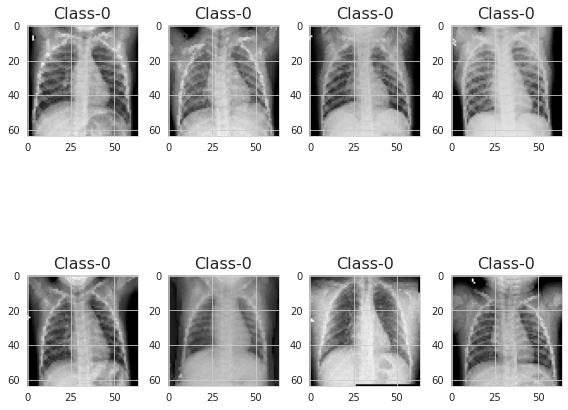

In [36]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

In [37]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [38]:
normalize = True

x_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", x_train.shape)

x_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", x_val.shape)

x_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", x_test.shape)

anomaly, y_anomaly =preprocess_images(anomaly_org, y_anomaly, normalize=normalize)
print("Shape of X_test:", anomaly.shape)

100%|██████████| 1341/1341 [00:00<00:00, 20763.42it/s]


Shape of X_train: (1341, 64, 64, 3)


100%|██████████| 8/8 [00:00<00:00, 10972.67it/s]


Shape of X_val: (8, 64, 64, 3)


100%|██████████| 234/234 [00:00<00:00, 27408.39it/s]


Shape of X_test: (234, 64, 64, 3)


100%|██████████| 390/390 [00:00<00:00, 28743.25it/s]

Shape of X_test: (390, 64, 64, 3)


In [42]:
np.unique(y_train), np.unique(y_anomaly)

(array([0]), array([1]))

In [43]:
np.max(x_train), np.max(x_val), np.max(x_test), np.max(anomaly) 

(1.0, 1.0, 1.0, 1.0)

In [44]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, anomaly.shape, y_anomaly.shape 

((1341, 64, 64, 3),
 (1341,),
 (8, 64, 64, 3),
 (8,),
 (234, 64, 64, 3),
 (234,),
 (390, 64, 64, 3),
 (390,))

In [45]:
# Create the Encoder and Decoder#pass the gray scale input image of size(28,28,1)
inputs = tf.keras.Input(shape=(64, 64, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [46]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [47]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [55]:
# Clear previous logs
!rm -rf "../../logs"
from keras.callbacks import TensorBoard

In [56]:
!mkdir "../../logs"
!ls "../../logs"

In [57]:
hist=autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir="../../logs")]
                )

Epoch 1/10
11/11 [==============================] - 5s 473ms/step - loss: 0.0544 - val_loss: 0.5508
Epoch 2/10
11/11 [==============================] - 5s 462ms/step - loss: 0.0512 - val_loss: 0.5268
Epoch 3/10
11/11 [==============================] - 5s 463ms/step - loss: 0.0484 - val_loss: 0.5037
Epoch 4/10
11/11 [==============================] - 5s 465ms/step - loss: 0.0458 - val_loss: 0.4798
Epoch 5/10
11/11 [==============================] - 5s 463ms/step - loss: 0.0436 - val_loss: 0.4537
Epoch 6/10
11/11 [==============================] - 5s 456ms/step - loss: 0.0414 - val_loss: 0.4298
Epoch 7/10
11/11 [==============================] - 5s 455ms/step - loss: 0.0393 - val_loss: 0.4080
Epoch 8/10
11/11 [==============================] - 5s 461ms/step - loss: 0.0377 - val_loss: 0.3773
Epoch 9/10
11/11 [==============================] - 5s 463ms/step - loss: 0.0359 - val_loss: 0.3524
Epoch 10/10
11/11 [==============================] - 5s 460ms/step - loss: 0.0342 - val_loss: 0.3346

In [53]:
# %load_ext tensorboard
# %tensorboard --logdir="../../logs" #Specify the path in fit

8/8 [==============================] - 0s 17ms/step


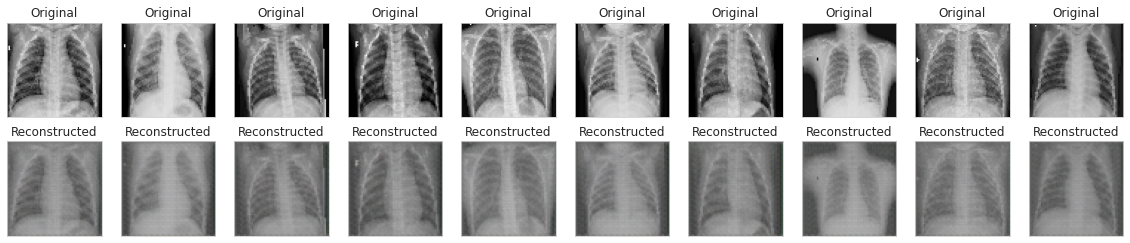

In [59]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

13/13 [==============================] - 0s 18ms/step


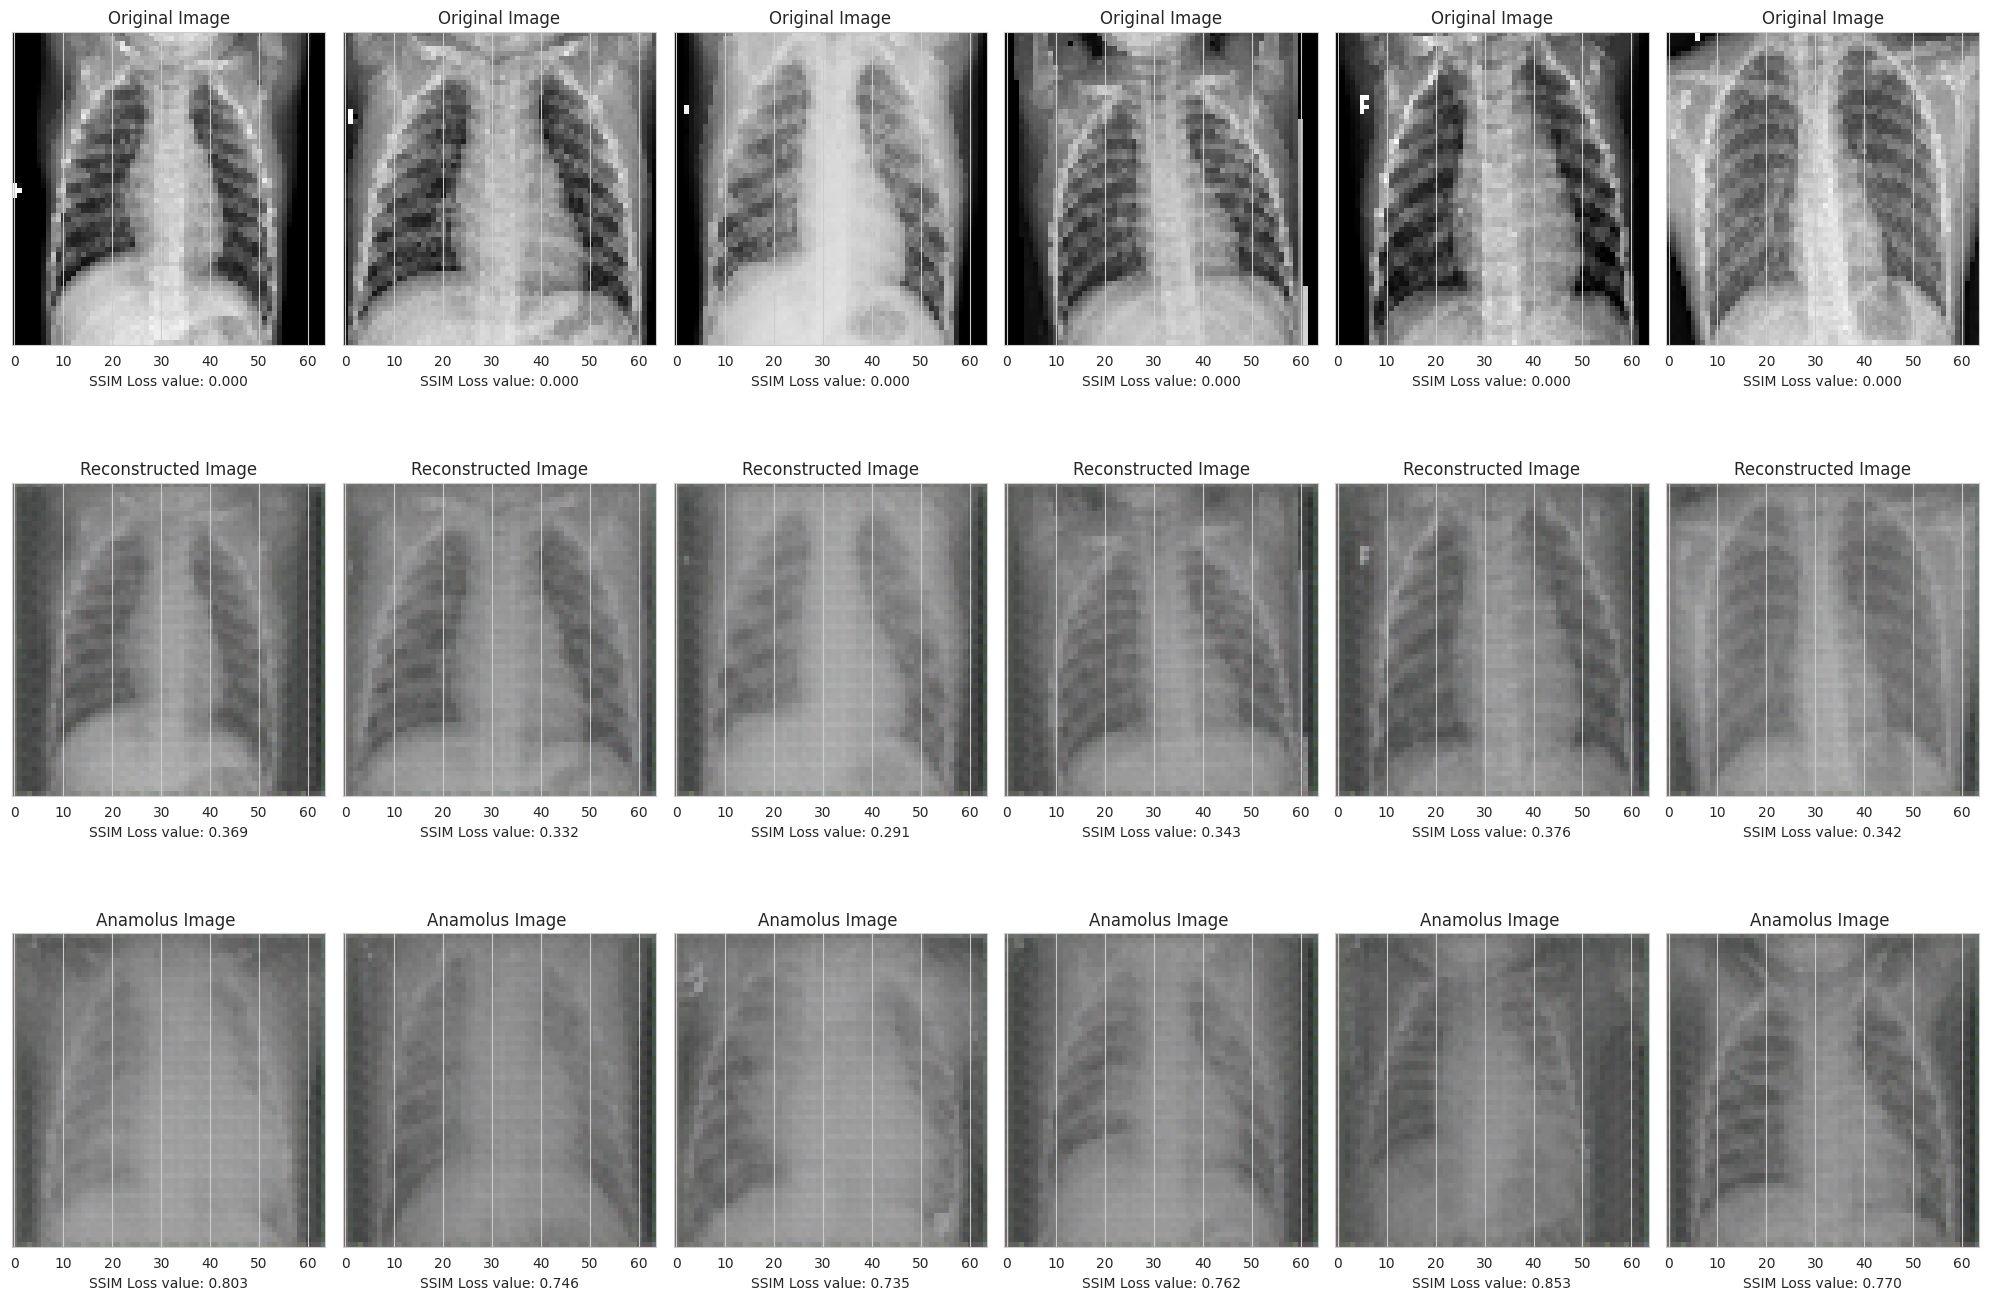

In [88]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display
decoded_imgs = autoencoder.predict(x_test)
decoded_pneumonia = autoencoder.predict(anomaly)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(x_test[i], x_test[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], x_test[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_pneumonia[i])
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_pneumonia[i], x_test[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()

In [65]:
decoded_pneumonia.shape, decoded_imgs.shape

((390, 64, 64, 3), (234, 64, 64, 3))

In [70]:
p = 230
ssim_normal = []
ssim_pneumonia = []
for i in range(p):
    # Potem spróbować jeszcze dla x_train
    ssim_normal.append(SSIMLoss(decoded_imgs[i], x_test[i]))
    ssim_pneumonia.append(SSIMLoss(decoded_pneumonia[i], x_test[i]))

In [71]:
len(ssim_normal), len(ssim_pneumonia)

(230, 230)

In [74]:
np.std(ssim_normal), np.std(ssim_pneumonia)

(0.022485767, 0.06665609)

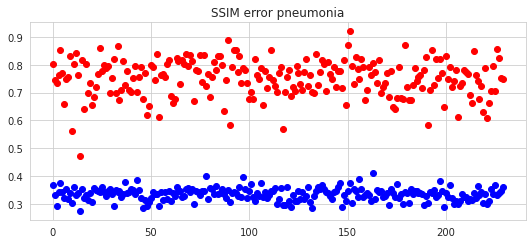

In [81]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("SSIM error pneumonia")
plt.plot(ssim_pneumonia, 'ro')
plt.plot(ssim_normal, 'bo')

plt.show()

In [83]:
!ls ../../

data  gradio  kn_venv  LICENSE	logs  models  notebooks  README.md


In [84]:
autoencoder.save("../../models/pneumonia_ae.h5")

In [86]:
p = 230
ssim_normal2 = []
ssim_pneumonia2 = []
for i in range(p):
    # Potem spróbować jeszcze dla x_train
    ssim_normal2.append(SSIMLoss(decoded_imgs[i], x_test[i]))
    ssim_pneumonia2.append(SSIMLoss(decoded_pneumonia[i], anomaly[i]))

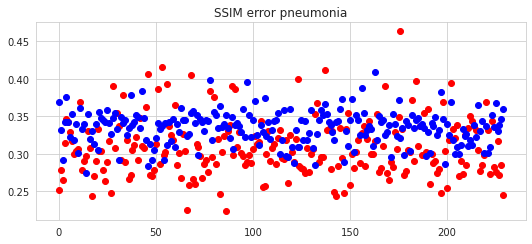

In [87]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("SSIM error pneumonia")
plt.plot(ssim_pneumonia2, 'ro')
plt.plot(ssim_normal2, 'bo')

plt.show()